<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

# This setting widens how many characters pandas will display 
# in a column:
pd.options.display.max_colwidth = 400

import re

---

## Load data

In [2]:
df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...
# df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [3]:
df['status_length'] = df['STATUS'].str.len()

In [4]:
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11


**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [5]:
df['status_word_count'] = df['STATUS'].apply(lambda x: len(x.split()))

In [6]:
# Check result
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11,3


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [7]:
# Five longest statuses
df.sort_values(by='status_word_count', ascending=False).head()[['STATUS']]

,STATUS
496,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ..."
6989,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost this if your proud of who you are! x x"
5208,"can't believe it. I got the new Wii Fit Plus game, it has a lot of fun new games and features. However, after not using the wii fit for a few months we decided to do the fitness test stuff again. Me(since last time): +2.9 lbs, still a healthy weight and BMI, wii age 54. *PROPNAME*: -8.6lbs, reccommends a healthy weight of gaining 6lbs, wii age 32. On the positive side, I have lost 5 of the 8 l..."
7976,"""I said he's a fairy I do suppose//flyin thru the air in pantyhose//he may be very sexy or even cute//but he looks like a sucka in a blue and red suit//I said you need a man who's got finesse//& his whole name across his chest//he may be able to fly all thru the night//but can he rock a party til the early light//he can't satisfy you with his little worm//but I can bust you out w my Super sper..."
5680,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do."


In [8]:
# Five shortest statuses
df.sort_values(by='status_word_count', ascending=False).tail(5)[['STATUS']]

,STATUS
6836,Meh.
818,død
6844,caved.
6851,):
5669,Tokyo.


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

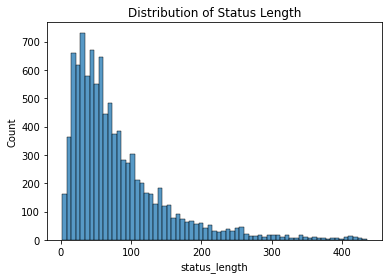

In [9]:
sns.histplot(data=df, x='status_length')
plt.title('Distribution of Status Length');

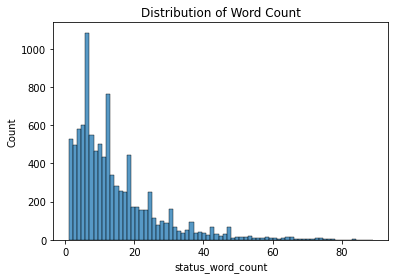

In [10]:
sns.histplot(data=df, x='status_word_count')
plt.title('Distribution of Word Count');

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

In [11]:
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11,3


In [12]:
# Get columns
scores_columns = df.columns[df.columns.str.contains('s[A-Z]')].tolist()
scores_columns

['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']

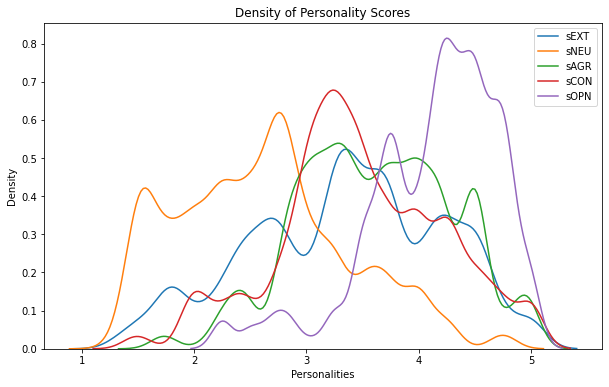

In [13]:
# Density plot
plt.figure(figsize=(10, 6))
for col in scores_columns:
    sns.kdeplot(x=col, data=df, label=col)
plt.legend()
plt.title('Density of Personality Scores')
plt.xlabel('Personalities');



---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [14]:
# Find unique users
df['#AUTHID'].nunique()

## There are 250 unique users in this dataset.

250

In [15]:
# Posts per user
df.shape[0] / df['#AUTHID'].nunique()

# In the dataset, average posts per user is ~40 posts.

39.664

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [16]:
# Drop duplicate users
unique_users = df.drop_duplicates(subset='#AUTHID')

# Drop unused columns
unique_users = unique_users.drop(columns=['STATUS', 'DATE', 'status_length', 'status_word_count'])

In [17]:
# Check result
print(unique_users.shape)
unique_users.head()

## The result is the same as mentioned above

(250, 11)


,#AUTHID,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN
0,b7b7764cfa1c523e4e93ab2a79a946c4,2.65,3.00,3.15,3.25,4.40,n,y,n,n,y
102,318bf822d4f2bd3920367560218619c0,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n
171,ecbddbfe00e0f83cfdb802a7186061c7,4.30,2.15,3.60,3.30,4.10,y,n,y,n,y
236,db39f7b2aad360b1033ec1f8fcd57f9c,4.65,3.20,3.05,3.65,4.75,y,y,n,y,y
246,4d035bd3fd8d9595d15cea9e388964be,3.70,2.90,3.40,3.35,4.05,y,y,n,n,y


**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

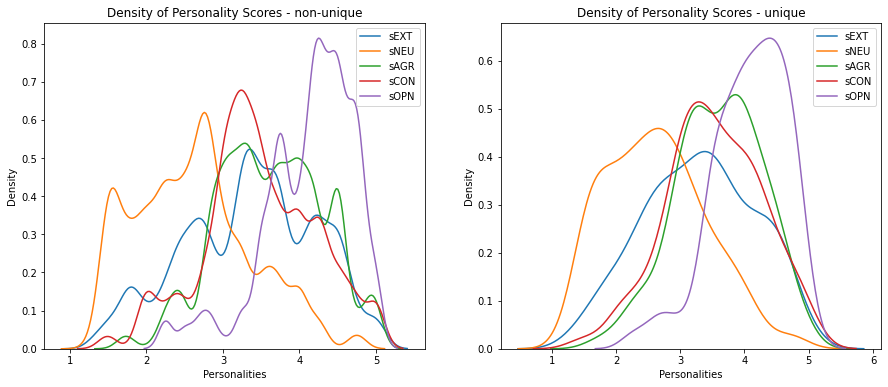

In [18]:
# Compare non-unique and unique datasets by density ploting

# Create dict of dataframe
df_dict = {'non-unique': df, 'unique': unique_users}

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for i, key in enumerate(df_dict):
    for col in scores_columns:
        sns.kdeplot(x=col, data=df_dict[key], label=col, ax=axs[i])
    axs[i].legend()
    axs[i].set_title(f'Density of Personality Scores - {key}')
    axs[i].set_xlabel('Personalities');
    
## The distribution of non-unique and unique datasets look different.
## We need to compare each personality for unique and non-unique one by one to understand more about the difference. 

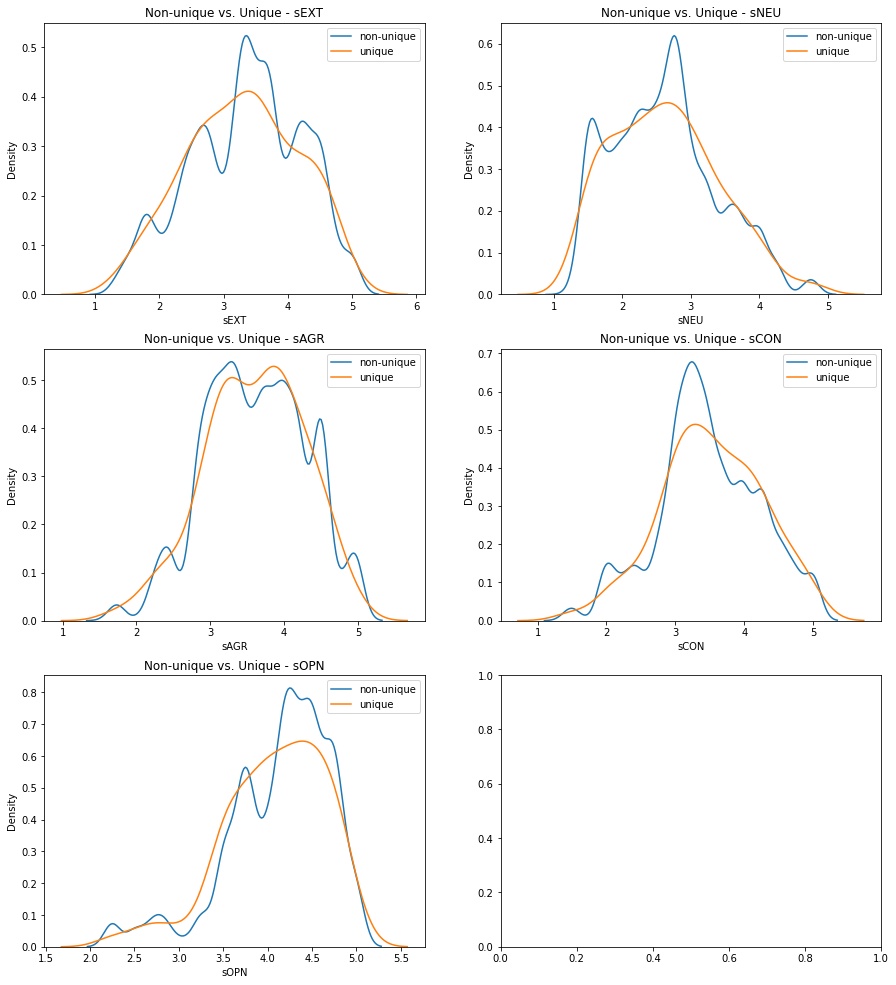

In [19]:
# Compare each personality one by one.

fig, axs = plt.subplots(3, 2, figsize=(15, 17))

for i, col in enumerate(scores_columns):
    x = i // 2
    y = i % 2
    for key in df_dict:
        sns.kdeplot(x=col, data=df_dict[key], label=key, ax=axs[x,y])
        axs[x,y].legend()
        axs[x,y].set_title(f'Non-unique vs. Unique - {col}')
        
# After comparing non-unique vs. unique one by one, distributions look different.
# Non-unique dataset is more fluctuating than unique one.

**Use the `.describe()` method on `unique_users`:**

In [20]:
unique_users.describe()

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.000000,250.000000,250.000000,250.000000,250.00000
mean,3.292120,2.627240,3.600320,3.522920,4.07856
std,0.861368,0.776835,0.670758,0.740211,0.57506
min,1.330000,1.250000,1.650000,1.450000,2.25000
25%,2.662500,2.000000,3.150000,3.000000,3.75000
50%,3.300000,2.590000,3.660000,3.500000,4.15000
75%,4.000000,3.150000,4.100000,4.050000,4.50000
max,5.000000,4.750000,5.000000,5.000000,5.00000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

In [21]:
# The distribution plot of scores can easily explain for roughly detail of data.
# Such as what data shape looks like. And easy to compare two variable distributions together.

# Summary statistics will be very useful when we need too look and many angles.
# For example: Compare many columns at once. It also gives specific information of data distribution.
# It's easily to see mean, median, std.

#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

In [22]:
# Openness
# Conscientiousness
# Extroversion
# Agreeableness
# Neuroticism

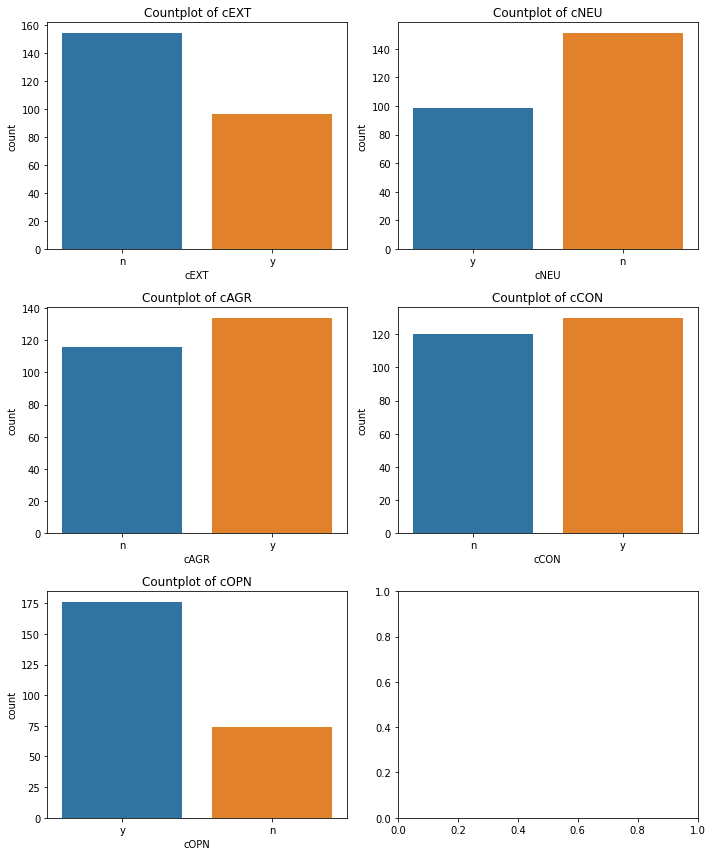

In [23]:
# Bar charts per category per trait
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

for i, col in enumerate(unique_users.columns[unique_users.columns.str.contains('c[A-Z]')]):
    x = i // 2
    y = i % 2
    sns.countplot(x=col, data=unique_users, ax=axs[x,y]).set_title(f'Countplot of {col}')
plt.tight_layout();

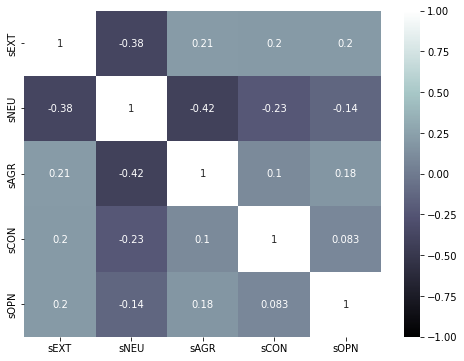

In [24]:
# Seaborn correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(unique_users.corr(), annot=True, cmap='bone', vmin=-1, vmax=1);

## For the result, the most correlated traits are Agreeableness and Neuroticism.

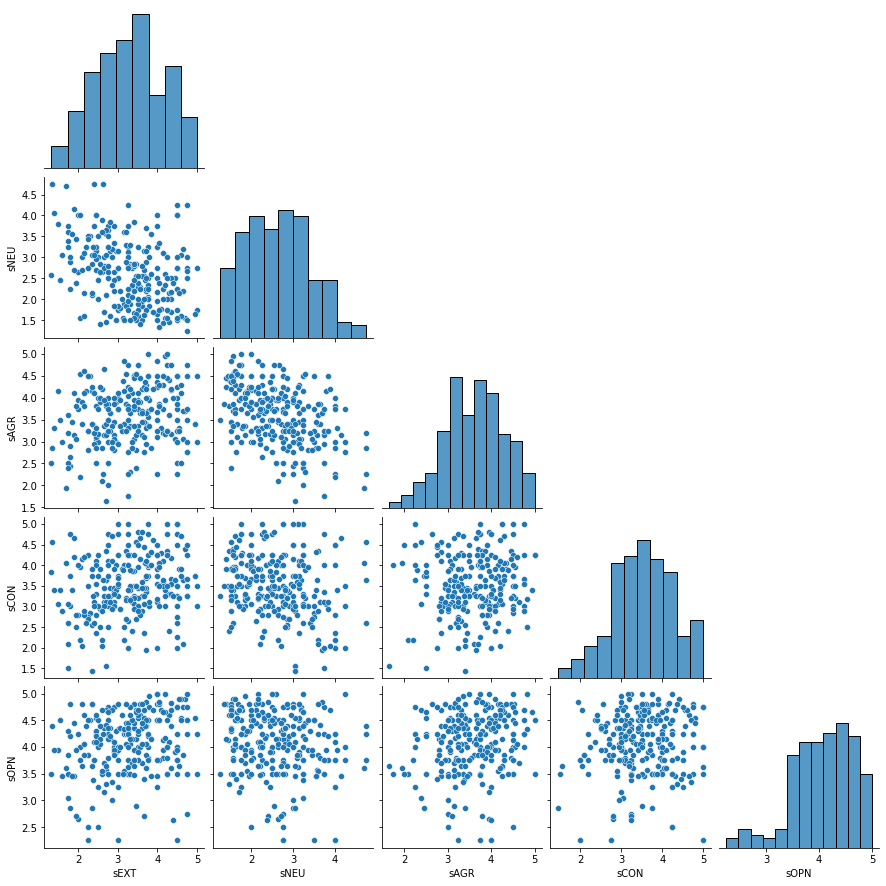

In [25]:
# Seaborn pairplot
sns.pairplot(unique_users, corner=True);

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

In [26]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [27]:
for col in df.columns[df.columns.str.contains('c[A-Z]')]:
    print(df.groupby(col)[['status_length', 'status_word_count']].mean())
    print('------------------------------------------')
    
## No difference for status length and word count in each personality.

      status_length  status_word_count
cEXT                                  
n         79.866655          14.394428
y         81.704918          14.702305
------------------------------------------
      status_length  status_word_count
cNEU                                  
n         80.852396          14.548314
y         80.304278          14.486414
------------------------------------------
      status_length  status_word_count
cAGR                                  
n         80.976769          14.616692
y         80.355800          14.444276
------------------------------------------
      status_length  status_word_count
cCON                                  
n         81.920149          14.709515
y         79.149034          14.308165
------------------------------------------
      status_length  status_word_count
cOPN                                  
n         85.686298          15.450726
y         78.905143          14.205184
------------------------------------------


**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

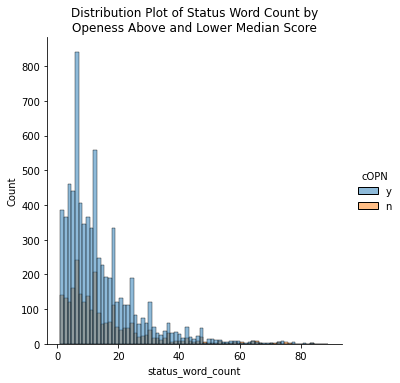

In [28]:
sns.displot(x='status_word_count', data=df, hue='cOPN')
plt.title('Distribution Plot of Status Word Count by\nOpeness Above and Lower Median Score');

# Status counts both above and below median scores are the same distribution shape.

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [29]:
# Instantiate a CountVectorizer object
# Remove stop words
cvec = CountVectorizer(stop_words='english')

# Fit CountVectorizer
status_vector = cvec.fit_transform(df['STATUS'])

# Convert to dataframe
status_df = pd.DataFrame(status_vector.todense(),
                           columns=cvec.get_feature_names_out())

In [30]:
# Check dataframe after vectorizing
status_df.shape

## After vectorizing by Countvectorized, we get 15_183 tokens.

(9916, 15183)

### Show the 15 most common words

In [31]:
# 15 most common words
status_df.sum().sort_values(ascending=False)[:15]

propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64

### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

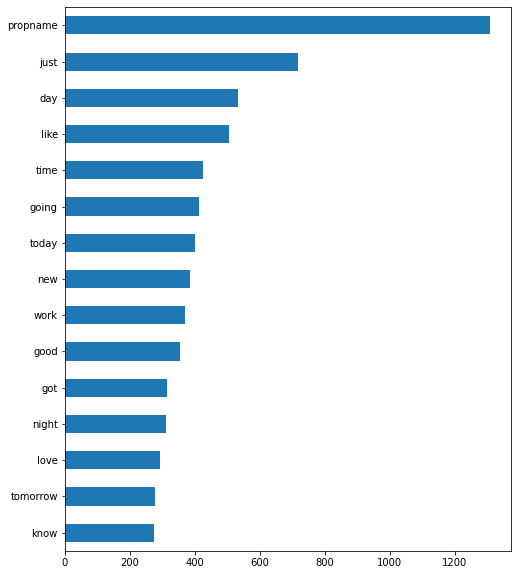

In [32]:
status_df.sum().sort_values(ascending=False)[:15].sort_values().plot(kind='barh', figsize=(8, 10));

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [33]:
df[df['STATUS'].str.lower().str.contains('propname')]['STATUS'].head(10)

6                                                                                                                                                                                                                                                         saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.
18                                                                                                                                                                                                                                                                                                         is tired. *PROPNAME*, let me go to sleep pl0x.
69                                                                                                                                                                                                              has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named

**Provide a short explanation of what you believe `propname` to be:**

In [34]:
# propname could be name or any identifier that can refer to a person.

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [35]:
text_and_scores = df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']].merge(status_df, left_index=True, right_index=True)

In [36]:
# Check head
text_and_scores.head()

,cEXT,cNEU,cAGR,cCON,cOPN,00,000,000ft,00am,00pm,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,n,y,n,n,y,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Show the 25 most common words for statuses from high-cAGR users:**

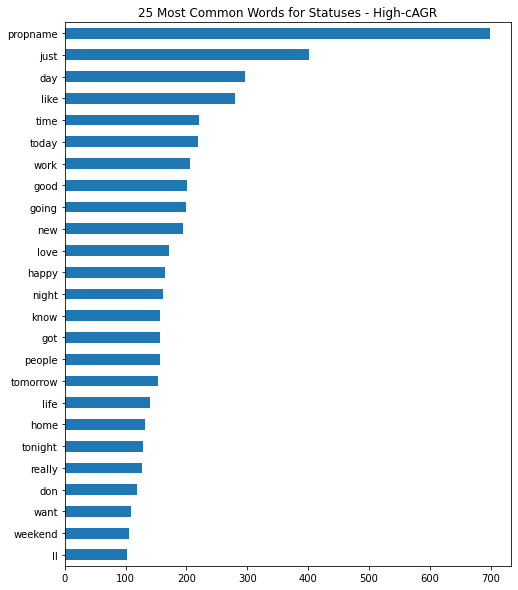

In [37]:
text_and_scores[text_and_scores['cAGR'] == 'y'].drop(columns=['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'])\
    .sum().sort_values(ascending=False)[:25].sort_values()\
    .plot(kind='barh', figsize=(8, 10))
plt.title('25 Most Common Words for Statuses - High-cAGR');

**Show the 25 most common words for statuses from low-cAGR users:**

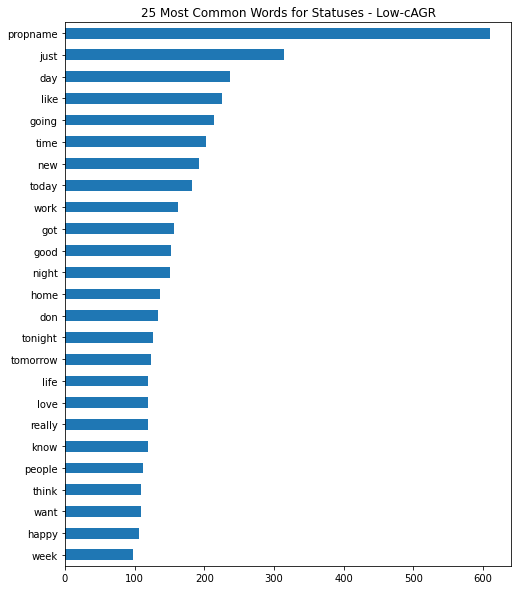

In [38]:
text_and_scores[text_and_scores['cAGR'] == 'n'].drop(columns=['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'])\
    .sum().sort_values(ascending=False)[:25].sort_values()\
    .plot(kind='barh', figsize=(8, 10))
plt.title('25 Most Common Words for Statuses - Low-cAGR');

In [39]:
# Create function to compare most common words by personality
def compare_commonword(data, dropvars, usevar, top_num):
    '''Compare common words use by given binary group'''
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))
    
    # plot axs 1
    data[data[usevar] == 'y'].drop(columns=dropvars).sum()\
    .sort_values(ascending=False)[:top_num].sort_values()\
    .plot(kind='barh', ax=axs[0])
    axs[0].set_title(f'Word Counts - {usevar} - High')
    
    # plot axs 2
    data[data[usevar] == 'n'].drop(columns=dropvars).sum()\
    .sort_values(ascending=False)[:top_num].sort_values()\
    .plot(kind='barh', ax=axs[1])
    axs[1].set_title(f'Word Counts - {usevar} - Low')
    
    plt.tight_layout()
    
    
    

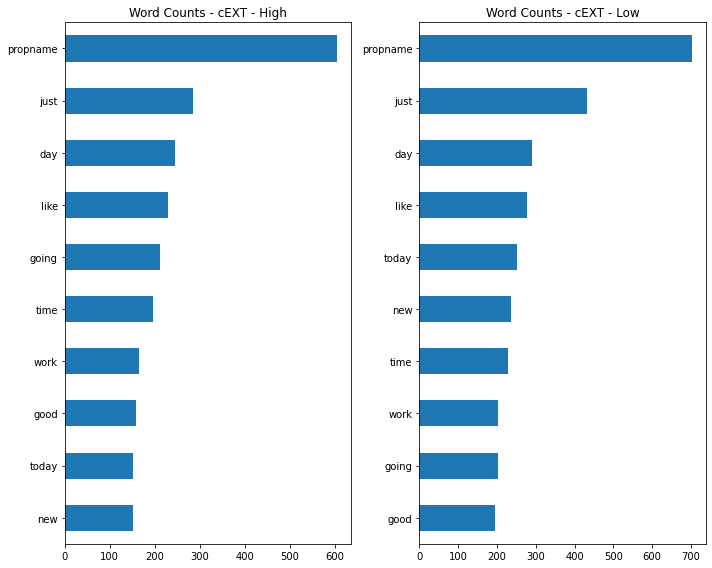

In [40]:
# Compare word counts - EXT
compare_commonword(text_and_scores, ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'], 'cEXT', 10)

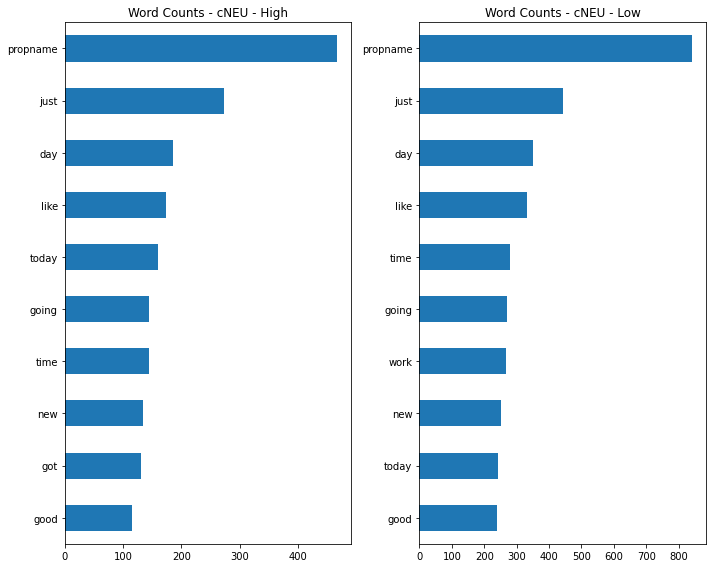

In [41]:
# Compare word counts - NEU
compare_commonword(text_and_scores, ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'], 'cNEU', 10)

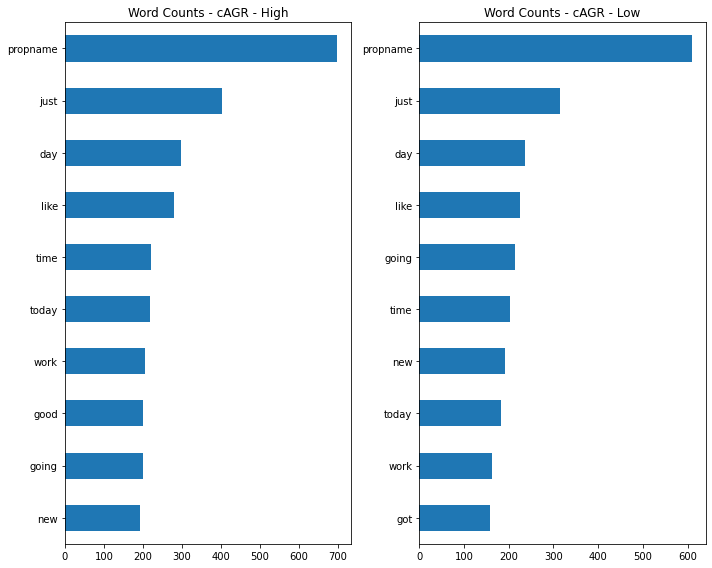

In [42]:
# Compare word counts - AGR
compare_commonword(text_and_scores, ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'], 'cAGR', 10)

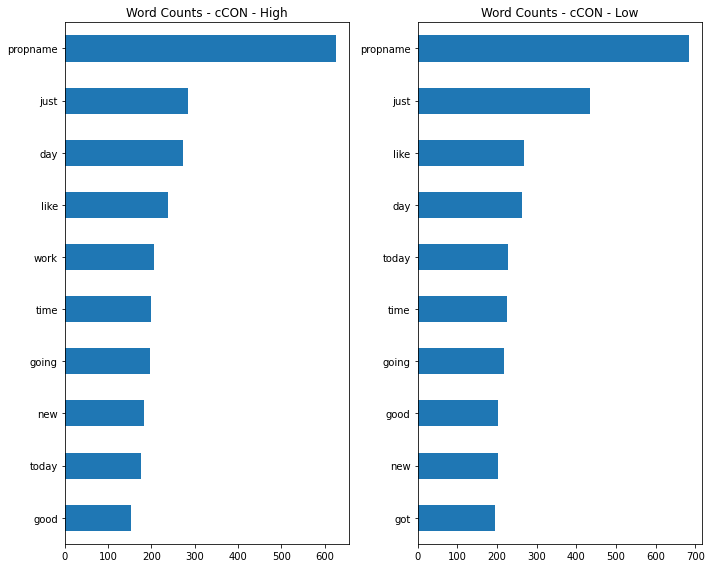

In [43]:
# Compare word counts - CON
compare_commonword(text_and_scores, ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'], 'cCON', 10)

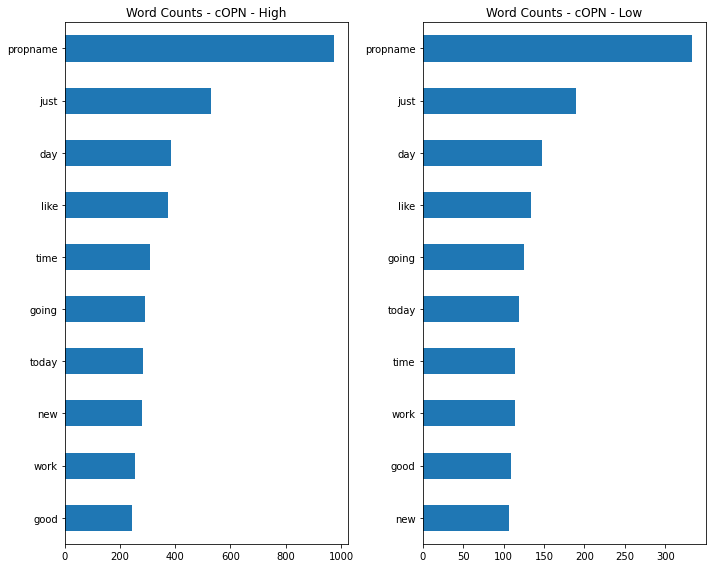

In [44]:
# Compare word counts - OPN
compare_commonword(text_and_scores, ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'], 'cOPN', 10)

### (BONUS) Most common bigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [bigrams](https://en.wikipedia.org/wiki/Bigram) in the dataset.

In [45]:
# Innitiate CountVectorizer
cvec_bi = CountVectorizer(ngram_range=(2,2), max_features=10)

status_vec_bi = cvec_bi.fit_transform(df['STATUS'])

status_df_bi = pd.DataFrame(status_vec_bi.todense(), columns=cvec_bi.get_feature_names_out())

In [46]:
# Top 10 common bigrams without removing stopwords.
status_df_bi.sum().sort_values(ascending=False)

## Most of common bigrams words are preposition + 'the'

in the      448
of the      323
for the     318
going to    295
to the      290
to be       284
on the      217
at the      172
to get      165
to go       162
dtype: int64

### (BONUS) Most common trigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [trigrams](https://en.wikipedia.org/wiki/Trigram) in the dataset.

In [47]:
# Innitiate CountVectorizer
cvec_tri = CountVectorizer(ngram_range=(3,3), max_features=10)

status_vec_tri = cvec_tri.fit_transform(df['STATUS'])

status_df_tri = pd.DataFrame(status_vec_tri.todense(), columns=cvec_tri.get_feature_names_out())

In [48]:
# Top 10 common trigrams without removing stopwords.
status_df_tri.sum().sort_values(ascending=False)

## ... 'going to' ... is more common to use when we consider trigrams words.

is going to                   93
propname and propname         56
going to be                   45
looking forward to            41
to go to                      38
going to the                  35
propname propname propname    34
out of the                    32
in the morning                29
the rest of                   28
dtype: int64

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

In [49]:
# Have numbers been redacted
df['STATUS'][df['STATUS'].str.contains('-\d{4}')].head()
## Some phone numbers have not been redacted.

2229                                                                                                                   has a new cell number: (229) 251-4618.  Save it now.  SAVE IT!
2242                                                                                                                                                  New cell number: (555) 555-5555
3958    Read about a horror movie you'll otherwise overlook on my site page. http:////www.examiner.com//examiner//x-24676-Gainesville-Film-Industry-Examiner~y2009m10d6-Trick-r-Treat
3963                            It Might Get Loud' in my latest article. http:////www.examiner.com//examiner//x-24676-Gainesville-Film-Industry-Examiner~y2009m10d9-It-Might-Get-Loud
3965                                  I bleed articles for your wholesale. http:////www.examiner.com//examiner//x-24676-Gainesville-Film-Industry-Examiner~y2009m10d22-New-Movies-Woo
Name: STATUS, dtype: object

In [50]:
# Investigate if any public figures or famous people show up in the dataset
df['STATUS'][df['STATUS'].str.contains('Obama')].head()

## The presitdent at that time was still showing the name without redacted.

799                                                                                                                                                                                                                                              prøver å forsvare Obama til min norsk romkamerat på norsk og det er utrolig vanskelig.
2096                                                                                                                                                                                                                                                                               Can Obama will the US to victory over Brazil Sunday?
3881    An Obama consultant yesterday on taxing high-value, middle class health care plans: "We're not talking about a new tax on these people. We're saying they currently get an enormous tax break and we're going to slightly scale that back . . ." This will likely be the talking point for any new, middle-class taxes to come.
6355            

In [51]:
# Is count of uppercase letters vs. lowercase letters per status related 
# to any personality category or personality score?

# Add count uppercase latters in statuses.
df['status_upper_count'] = df['STATUS'].str.count('[A-Z]')
df['status_lower_count'] = df['STATUS'].str.count('[a-z]')

In [52]:
# Average grouby for upper and lower counts
for col in df.columns[df.columns.str.contains('c[A-Z]')]:
    print(df.groupby(col)[['status_upper_count', 'status_lower_count']].mean())
    print('------------------------------------------')
    
## No difference in upper and lower counts to any personality.

      status_upper_count  status_lower_count
cEXT                                        
n               4.127212           56.953040
y               4.267047           58.133048
------------------------------------------
      status_upper_count  status_lower_count
cNEU                                        
n               4.130505           57.729634
y               4.280065           56.994081
------------------------------------------
      status_upper_count  status_lower_count
cAGR                                        
n               4.211443           57.713487
y               4.164610           57.224796
------------------------------------------
      status_upper_count  status_lower_count
cCON                                        
n               4.251306           58.248507
y               4.110404           56.519096
------------------------------------------
      status_upper_count  status_lower_count
cOPN                                        
n               4.

---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [exploratory vs. explanatory analysis](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.

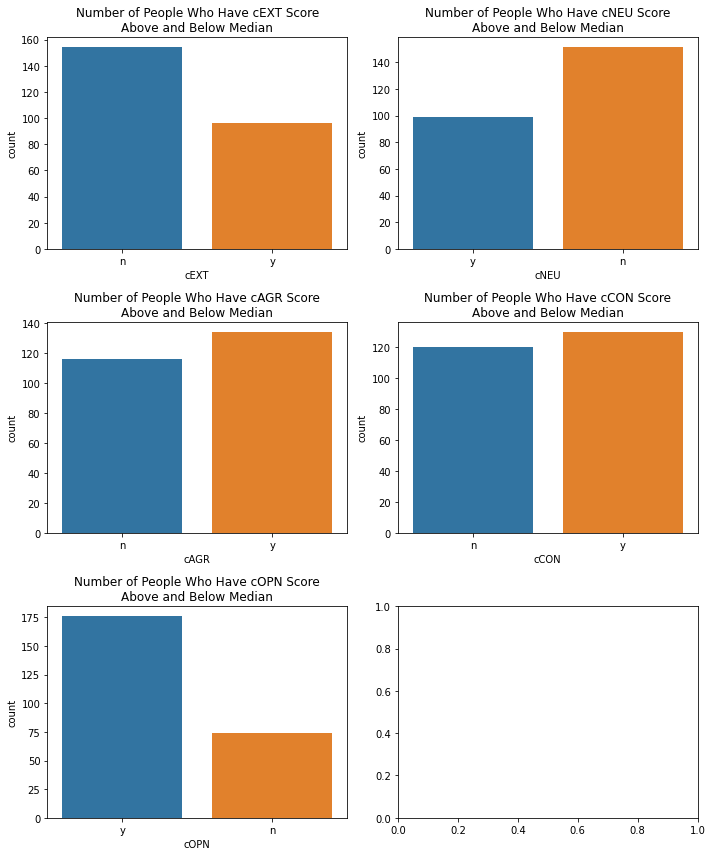

In [53]:
# Bar charts per category per trait
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

for i, col in enumerate(unique_users.columns[unique_users.columns.str.contains('c[A-Z]')]):
    x = i // 2
    y = i % 2
    sns.countplot(x=col, data=unique_users, ax=axs[x,y])\
    .set_title(f'Number of People Who Have {col} Score\nAbove and Below Median')
plt.tight_layout();

        From Above charts, 250 persons who posted statuses in the dataset, There are 2 personality traits that have large different scores between above and below median which are extraversion and openness to experience.
        Surprisingly, in this dataset, number of persons who have extraversion score above median is less than persons who have score below median. However, number of persons who have above median score for openness to experience is higher than the below one which could imply that a person, who is more inventive, is likely to post statuses more and was captured into this dataset.